# Проверка гипотез по увеличению выручки в интернет-магазине - оценить результаты А/В теста.

<a id="begin"></a>

**Оглавление** 

1. [Описание проекта](#project)
2. [Описание данных](#data)
3. [Предобработка данных](#start)
4. Приоритизация гипотез
    * [применение фреймворка ICE для приоритизации гипотез;](#ice)
    * [применение фреймворка RICE для приоритизации гипотез;](#rice)
    * [результат приоритизации гипотез.](#result)
5. [Анализ A/B-теста](#abtest)
    * [построение графика кумулятивной выручки по группам;](#graffic_1)
    * [построение графика кумулятивного среднего чека по группам;](#graffic_2)
    * [построение графика относительного изменения кумулятивного среднего чека
    группы В к группе А;](#graffic_3)
    * [построение графика кумулятивной конверсии по группам;](#graffic_4)
    * [построение графика относительного различия кумулятивных конверсий;](#graffic_5)
    * [построение точечного графика количества заказов по пользователям;](#graffic_6)
    * [расчёт 95-го и 99-го перцентилей количества заказов на пользователя;](#percentile_1)
    * [построение точечного графика стоимостей заказов;](#graffic_7)
    * [расчёт 95-го и 99-го перцентилей стоимости заказов;](#percentile_2)
    * [расчёт статистической значимости различий в конверсии между группами по «сырым» данным;](#pvalue_1)
    * [расчёт статистической значимости различий в среднем чеке заказа между группами по «сырым» данным;](#pvalue_2)
    * [расчёт статистической значимости различий в конверсии между группами по «очищенным» данным;](#pvalue_3)
    * [расчёт статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным.](#pvalue_4)
6. [Решение по результатам анализа теста.](#decision)
    

<a id="project"></a>

## Описание проекта
[(к оглавлению)](#begin)

**Вместе с отделом маркетинга мы подготовили список гипотез для увеличения выручки крупного интернет-магазина**

*Задачи работы:*
- приоритизировать гипотезы;
- запустить A/B-тест;
- проанализировать результаты.

<a id="data"></a>

## Описание данных 
[(к оглавлению)](#begin)

**Данные для первой части**

*Файл /hypothesis.csv*
- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

**Данные для второй части**

*Файл /orders.csv*

- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

*Файл /visitors.csv*
- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста.

<a id="start"></a>

 ## Предобработка данных 
 [(к оглавлению)](#begin)

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
hypothesis = pd.read_csv('/hypothesis.csv')
orders = pd.read_csv('/orders.csv')
visitors = pd.read_csv('/visitors.csv')

In [3]:
#Функция для предобработки
def inspect(df):
    display(df.head()) 
    df.info() 
    print ('Количество дубликатов -', df.duplicated().sum())
    numeric_columns=df.describe().columns
    display(df.describe())
    display()
    df.columns = [x.lower().replace(' ', '_') for x in df.columns.values]
    for column_name in df.columns:
        if column_name not in numeric_columns:
            if 'session' in column_name or 'dt' in column_name:
                df[column_name] = pd.to_datetime(df[column_name])
            else:
                display(df[column_name].value_counts())
                print(50*'*')
    return df.head(10)

In [4]:
pd.set_option('max_colwidth', 400)

In [5]:
inspect(hypothesis)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
Количество дубликатов - 0


,Reach,Impact,Confidence,Efforts
count,9.000000,9.000000,9.000000,9.000000
mean,4.777778,4.777778,5.555556,4.888889
std,3.153481,3.192874,3.045944,2.803767
min,1.000000,1.000000,1.000000,1.000000
25%,3.000000,3.000000,3.000000,3.000000
50%,3.000000,3.000000,7.000000,5.000000
75%,8.000000,7.000000,8.000000,6.000000
max,10.000000,10.000000,9.000000,10.000000


Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей              1
Запустить собственную службу доставки, что сократит срок доставки заказов                                       1
Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа    1
Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар             1
Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей                                1
Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов                        1
Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию            1
Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок                1
Запустить акцию, дающую скидку на товар в день рождения                                 

**************************************************


3     3
8     2
2     1
5     1
10    1
1     1
Name: reach, dtype: int64

**************************************************


3     3
10    1
5     1
1     1
2     1
7     1
9     1
Name: impact, dtype: int64

**************************************************


8    3
4    1
7    1
3    1
1    1
2    1
9    1
Name: confidence, dtype: int64

**************************************************


3     3
5     2
6     1
10    1
8     1
1     1
Name: efforts, dtype: int64

**************************************************


,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [6]:
inspect(orders)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
Количество дубликатов - 0


,transactionId,visitorId,revenue
count,1.197000e+03,1.197000e+03,1.197000e+03
mean,2.155621e+09,2.165960e+09,8.348006e+03
std,1.229085e+09,1.236014e+09,3.919113e+04
min,1.062393e+06,5.114589e+06,5.000000e+01
25%,1.166776e+09,1.111826e+09,1.220000e+03
50%,2.145194e+09,2.217985e+09,2.978000e+03
75%,3.237740e+09,3.177606e+09,8.290000e+03
max,4.293856e+09,4.283872e+09,1.294500e+06


3667963787    1
4167421281    1
2875229767    1
504373597     1
2017680897    1
             ..
1853288890    1
2084190534    1
2956594374    1
3646798055    1
3936777065    1
Name: transactionid, Length: 1197, dtype: int64

**************************************************


4256040402    11
2458001652    11
2378935119     9
2038680547     8
199603092      5
              ..
2524310328     1
2210805728     1
2274825520     1
1831227158     1
2108080724     1
Name: visitorid, Length: 1031, dtype: int64

**************************************************


2019-08-05    48
2019-08-14    47
2019-08-12    47
2019-08-06    46
2019-08-15    46
2019-08-01    45
2019-08-28    45
2019-08-02    44
2019-08-27    44
2019-08-08    43
2019-08-19    43
2019-08-29    42
2019-08-07    42
2019-08-22    41
2019-08-09    41
2019-08-26    41
2019-08-03    40
2019-08-23    40
2019-08-10    39
2019-08-16    38
2019-08-21    37
2019-08-30    35
2019-08-13    35
2019-08-04    33
2019-08-20    32
2019-08-31    32
2019-08-24    31
2019-08-11    26
2019-08-18    26
2019-08-17    24
2019-08-25    24
Name: date, dtype: int64

**************************************************


B    640
A    557
Name: group, dtype: int64

**************************************************


,transactionid,visitorid,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
6,398296753,2900797465,2019-08-15,1860,B
7,2626614568,78758296,2019-08-15,1044,A
8,1576988021,295230930,2019-08-15,13710,A
9,1506739906,1882260405,2019-08-15,1855,B


In [7]:
orders = orders.rename(columns={'transactionid': 'transaction_id', 'visitorid': 'visitor_id'})

In [8]:
inspect(visitors)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
Количество дубликатов - 0


,visitors
count,62.000000
mean,607.290323
std,114.400560
min,361.000000
25%,534.000000
50%,624.500000
75%,710.500000
max,770.000000


2019-08-01    2
2019-08-17    2
2019-08-30    2
2019-08-29    2
2019-08-28    2
2019-08-27    2
2019-08-26    2
2019-08-25    2
2019-08-24    2
2019-08-23    2
2019-08-22    2
2019-08-21    2
2019-08-20    2
2019-08-19    2
2019-08-18    2
2019-08-16    2
2019-08-02    2
2019-08-15    2
2019-08-14    2
2019-08-13    2
2019-08-12    2
2019-08-11    2
2019-08-10    2
2019-08-09    2
2019-08-08    2
2019-08-07    2
2019-08-06    2
2019-08-05    2
2019-08-04    2
2019-08-03    2
2019-08-31    2
Name: date, dtype: int64

**************************************************


A    31
B    31
Name: group, dtype: int64

**************************************************


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
5,2019-08-06,A,667
6,2019-08-07,A,644
7,2019-08-08,A,610
8,2019-08-09,A,617
9,2019-08-10,A,406


Проведены загрузка и первичное ознакомление с данными, выполнены предобработка и замена названия столбцов. Дубликаты и пропуски не обнаружены. Данные готовы к дальнейшему анализу. 

<a id="ice"></a>

## Приоритизация гипотез

### Применение фреймворка ICE для приоритизации гипотез.
[(к оглавлению)](#begin)

ICE — один из самых популярных способов приоритизации задач:
- impact — насколько сильно изменение повлияет на пользователей, их опыт и удовлетворение от продукта;
- confidence — насколько вы уверены, что это изменение повлияет на пользователей именно так;
- efforts — сколько стоит протестировать эту гипотезу.

<p>Для его определения воспользуемся формулой:</p>
<p>ICE = Impact * Confidence / Efforts</p>

In [9]:
hypothesis['ice'] = hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
display(hypothesis[['hypothesis', 'ice']].sort_values(by='ice', ascending=False))

,hypothesis,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000


<a id="rice"></a>

### Применение фреймворка RICE для приоритизации гипотез.
[(к оглавлению)](#begin)

У метода ICE есть модификация RICE (R от англ. reach, «охват»), которая учитывает охват влияния.
Приоритизируем гипотезу данным фреймворком

In [10]:
hypothesis['rice'] = hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']

display(hypothesis[['hypothesis', 'rice']].sort_values(by='rice', ascending=False))
display(hypothesis['hypothesis'].unique())

,hypothesis,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


array(['Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей',
       'Запустить собственную службу доставки, что сократит срок доставки заказов',
       'Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа',
       'Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар',
       'Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей',
       'Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов',
       'Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию',
       'Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок',
       'Запустить акцию, дающую скидку на товар в день рождения'],
      dtype=object)

<a id="result"></a>

### Результат приоритизации гипотез
[(к оглавлению)](#begin)

In [11]:
display(hypothesis[['hypothesis', 'rice']].sort_values(by='rice', ascending=False).head(4))
display(hypothesis[['hypothesis', 'ice']].sort_values(by='ice', ascending=False).head(4))

,hypothesis,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0


,hypothesis,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000


При проведении приоритизации гипотез методом ICE выделяются гипотезы: 8, 0, 7, 6. В то время как, при применении фреймворка RICE список гипотез уже: 7,2,0,6. Это связано с тем, что показатель reach выше чем у остальных, и данная гипотеза учитывает отхват пользователей. Таким образом, будет рассмотрена гипотеза о "Добавлении двух новых каналов привлечения трафика, что позволит привлекать на 30% больше пользователей".

<a id="abtest"></a>

## Анализ A/B-теста
[(к оглавлению)](#begin)

Определим корректно ли разбиты пользователи на группы, а именно, не попали ли они в обе группы одновременно.

In [12]:
double_visitors = np.intersect1d(orders.query('group == "A"')['visitor_id'].unique(),
                   orders.query('group == "B"')['visitor_id'].unique())
display(round((len(double_visitors) / orders['visitor_id'].count() * 100), 2))

4.85

Меньше 5% от общего количества пользователей составляют покупатели которые попали в обе группы, рационально их будет исключить из дальнейшего участия в тестировании.

In [13]:
orders[~orders['visitor_id'].isin(double_visitors)]

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
...,...,...,...,...,...
1191,3592955527,608641596,2019-08-14,16490,B
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A


<a id="graffic_1"></a>

### Построение графика кумулятивной выручки по группам.
[(к оглавлению)](#begin)

In [14]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

Агрегируем значения. Вычислим максимальную дату. Для группы тоже рассчитаем максимум, и хотя она будет определённой, сделаем это, чтобы столбец 'group' не пропал из итогового вывода. Найдём число уникальных ID заказов и пользователей. Подсчитаем сумму средних чеков, затем применим методы к каждой строке датафрейма и отсортируем результаты по столбцам .

In [15]:
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'],
                                                                     orders['group'] == x['group'])]
                                     .agg({'date' : 'max', 'group' : 'max', 'transaction_id' : 'nunique',
                                           'visitor_id' : 'nunique', 'revenue' : 'sum'})
                                     , axis=1).sort_values(by=['date','group'])

Аналогично получим агрегированные кумулятивные по дням данные о посетителях интернет-магазина:

In [16]:
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'],
                                                                         visitors['group'] == x['group'])]
                                       .agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'})
                                       , axis=1).sort_values(by=['date','group'])

Объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия

In [17]:
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'],
                                        right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
display(cumulativeData.head()) 

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


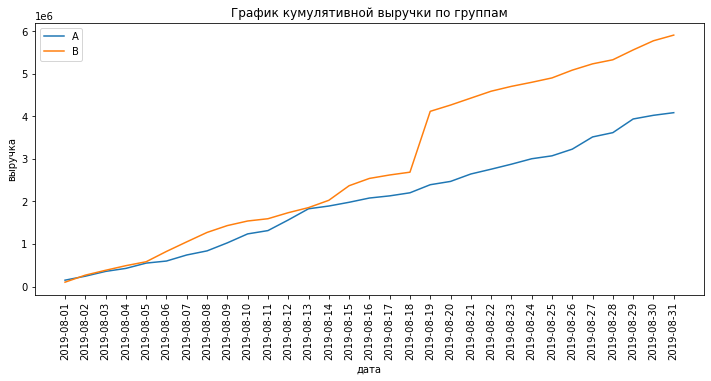

In [18]:
fig, ax = plt.subplots(figsize=(12, 5))

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.legend()
plt.xticks(rotation=90)
plt.ylabel("выручка")
plt.xlabel("дата")
plt.title('График кумулятивной выручки по группам')
plt.show()

Наблюдается равномерное увеличение выручки, однако виден резкий скачок, что может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке.

<a id="graffic_2"></a>

### Построение графика кумулятивного среднего чека по группам. 
[(к оглавлению)](#begin)

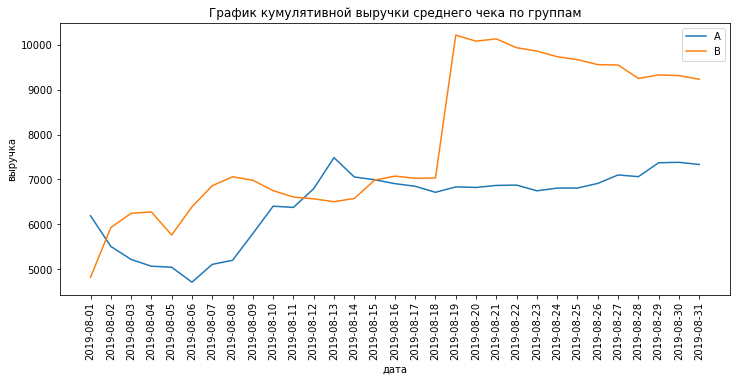

In [19]:
fig, ax = plt.subplots(figsize=(12, 5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend()
plt.xticks(rotation=90)
plt.ylabel("выручка")
plt.xlabel("дата")
plt.title('График кумулятивной выручки среднего чека по группам')
plt.show()

Средний чек также показывает резкий прирост выручки группы В, возможно в группу B попали крупные заказы (резкий всплеск на графике 19 числа). Тогда ей нужно больше данных, чтобы прийти к реальному среднему чеку и установиться на его уровне.

<a id="graffic_3"></a>

### Построение графика относительного изменения кумулятивного среднего чека группы B к группе A.
[(к оглавлению)](#begin)

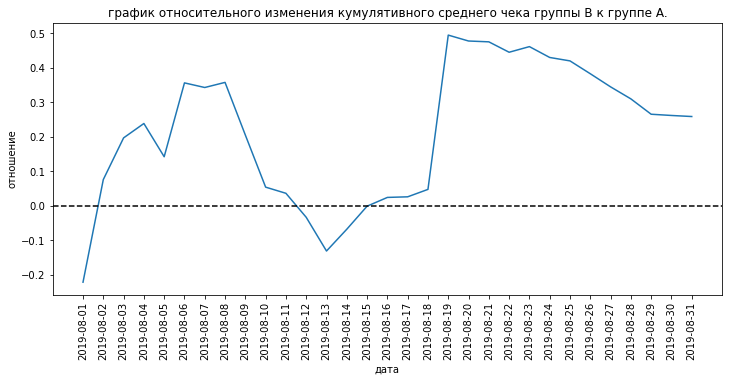

In [20]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date',
                                                   how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
fig, ax = plt.subplots(figsize=(12, 5))
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']
                                           /mergedCumulativeRevenue['ordersB'])
         /(mergedCumulativeRevenue['revenueA']
           /mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--') 
plt.xticks(rotation=90)
plt.title('график относительного изменения кумулятивного среднего чека группы B к группе A.')
plt.xlabel("дата")
plt.ylabel("отношение")
plt.show()

В нескольких точках график различия между сегментами резко «скачет», определенно есть большие заказы или выбросы. 

<a id="graffic_4"></a>

### Построение графика кумулятивной конверсии по группам. 
[(к оглавлению)](#begin)

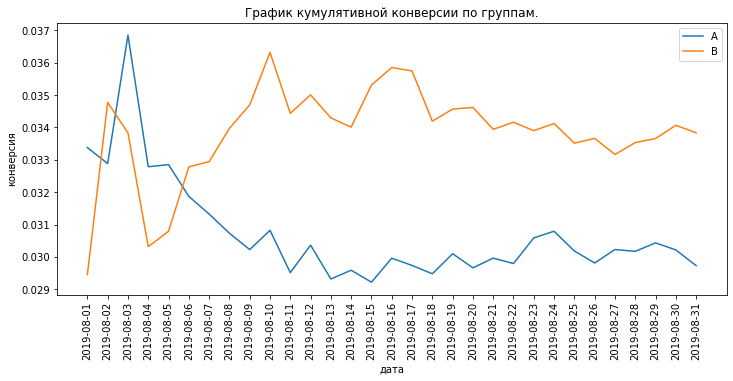

In [21]:
fig, ax = plt.subplots(figsize=(12, 5))
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()

# задаем масштаб осей
plt.xticks(rotation=90)
plt.title('График кумулятивной конверсии по группам.')
plt.ylabel("конверсия")
plt.xlabel("дата")
plt.show()

Наблюдаем резкие колебания в начале и постепенную стабилизацию со временем. Кумулятивная конверсия группы В значительно выше.

<a id="graffic_5"></a>

### Построение графика относительного различия кумулятивных конверсий.
[(к оглавлению)](#begin)

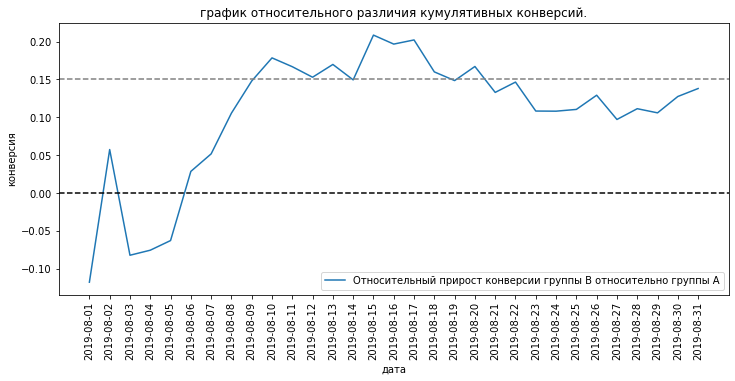

In [22]:
fig, ax = plt.subplots(figsize=(12, 5))
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']],
                                                                           left_on='date', right_on='date', how='left',
                                                                           suffixes=['A', 'B'])

plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']
         /mergedCumulativeConversions['conversionA']-1,
         label="Относительный прирост конверсии группы B относительно группы A")

plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.15, color='grey', linestyle='--')
plt.xticks(rotation=90)
plt.title('график относительного различия кумулятивных конверсий.')
plt.ylabel('конверсия')
plt.xlabel('дата')
plt.show()

В начале теста группа B значительно проигрывала группе A, затем вырвалась вперёд. Потом её конверсия снова падала, но теперь постепенно растёт.

<a id="graffic_6"></a>

### Построение точечного графика количества заказов по пользователям.
[(к оглавлению)](#begin)

In [23]:
# сгруппируем данные
ordersByUsers = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)

ordersByUsers.columns = ['user_id', 'orders']

print(ordersByUsers.sort_values(by='orders', ascending=False).head(10)) 

         user_id  orders
1023  4256040402      11
591   2458001652      11
569   2378935119       9
487   2038680547       8
44     199603092       5
744   3062433592       5
55     237748145       5
917   3803269165       5
299   1230306981       5
897   3717692402       5


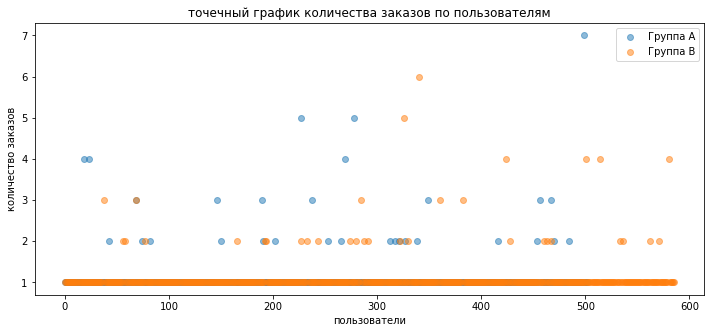

In [24]:
# Построим точечный график:
fig, ax = plt.subplots(figsize=(12, 5))

ordersByUsers_A = (orders
                .query('group == "A"')
                .groupby('visitor_id', as_index=False)
                .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsers_B = (orders
                .query('group == "B"')
                .groupby('visitor_id', as_index=False)
                .agg({'transaction_id': pd.Series.nunique})
)

x_values_A = pd.Series(range(0,len(ordersByUsers_A)))
x_values_B = pd.Series(range(0,len(ordersByUsers_B)))

plt.scatter(x_values_A, ordersByUsers_A['transaction_id'], label="Группа A", alpha=0.5) 
plt.scatter(x_values_B, ordersByUsers_B['transaction_id'], label="Группа B", alpha=0.5) 
plt.ylabel("количество заказов")
plt.xlabel("пользователи")
plt.title('точечный график количества заказов по пользователям')
plt.legend()
plt.show()

Много пользователей с 2-3 заказами. Считать их аномалиями или нет, мы не можем, поскольку их точная доля не ясна.

<a id="percentile_1"></a>

### Расчёт 95-го и 99-го перцентилей количества заказов на пользователя.
[(к оглавлению)](#begin)

In [25]:
display(np.percentile(ordersByUsers['orders'], [95, 99]))

array([2., 4.])

Не более 5% всех пользователей оформляли 2 заказа, и не более 1% - 4. Предлагаю выбрать нижнюю границу в 2 заказа,  и отсеять аномальных пользователей по ней.

<a id="graffic_7"></a>

### Построение точечного графика стоимостей заказов. 
[(к оглавлению)](#begin)

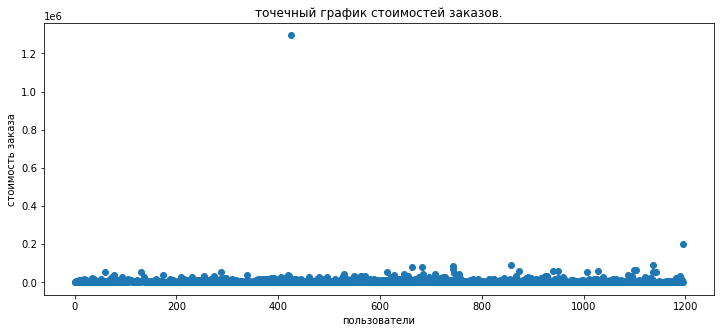

In [26]:
fig, ax = plt.subplots(figsize=(12, 5))
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue']) 
plt.ylabel("стоимость заказа")
plt.xlabel("пользователи")
plt.title('точечный график стоимостей заказов.')
plt.show()

Как и предполагалось, на графике видны аномально-большие заказы. 

<a id="percentile_2"></a>

### Расчёт 95-го и 99-го перцентилей стоимости заказов.
[(к оглавлению)](#begin)

In [27]:
display(np.percentile(orders['revenue'], [95, 99]))

array([28000. , 58233.2])

Не более 5% заказов дороже 28 000 рублей и не более 1% дороже 58234 рублей. За аномальные значения будем считать заказы дороже 28 000 рублей.

<a id="pvalue_1"></a>

###  Расчёт статистической значимости различий в конверсии между группами по «сырым» данным.
[(к оглавлению)](#begin)

Посчитаем статистическую значимость различий в конверсии и среднем чеке между группами по «сырым» данным — без удаления аномальных пользователей.

In [28]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

display(data.head())

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


Посчитаем статистическую значимость различия в конверсии между группами.

In [29]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitor_id', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
    
)
ordersByUsersB.columns = ['visitor_id', 'orders'] 

Объявим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули. Это нужно, чтобы подготовить выборки к проверке критерием Манна-Уитни.

In [30]:
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum()
                                                                           - len(ordersByUsersA['orders'])),
                                                        name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum()
                                                                           - len(ordersByUsersB['orders'])),
                                                        name='orders')],axis=0)

Выведем относительный прирост конверсии группы B. Округлим до трёх знаков после запятой.

<p>Нулевая гипотеза: статистически значимых различий в конверсии между группами по "сырым" данным нет.</p>
<p>Альтернативная гипотеза: статистически значимых различий в конверсии между группами по "сырым" данным есть.</p>

In [31]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitor_id', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitor_id', 'orders']

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

display("p_value = {0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

display("В/А = {0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))


'p_value = 0.017'

'В/А = 0.138'

p-value = 0.008,  меньше 0,05. Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами по "сырым" данным нет, отвергаем. 13,8% - выйгрыш группы В.

<a id="pvalue_2"></a>

### Расчёт статистической значимости различий в среднем чеке заказа между группами по «сырым» данным
[(к оглавлению)](#begin)

<p>Нулевая гипотеза: статистически значимых различий в среднем чеке заказа между группами по "сырым" данным нет .</p>
<p>Альтернативная гипотеза: статистически значимых различий в среднем чеке заказа между группами по "сырым" данным есть.</p>

In [32]:
display('p-value = {0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'],
                                            orders[orders['group']=='B']['revenue'])
                         [1]))
display('B/A = {0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()
                         /orders[orders['group']=='A']['revenue'].mean()
                         -1))

'p-value = 0.729'

'B/A = 0.259'

P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Cредний чек группы B значительно выше среднего чека группы A, но поскольку p-value > alpha выборки не показывают статистически значимое различие.

<a id="pvalue_3"></a>

### Расчёт статистической значимости различий в конверсии между группами по «очищенным» данным
[(к оглавлению)](#begin)

In [33]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['visitor_id'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['visitor_id'],
    ],
    axis=0,
)

revenue_lim = np.percentile(orders['revenue'], 95)
usersWithExpensiveOrders = orders[orders['revenue'] > revenue_lim]['visitor_id']

abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))
print(abnormalUsers.shape) 

1099    148427295
18      199603092
928     204675465
23      237748145
37      249864742
Name: visitor_id, dtype: int64
(74,)


Всего 74 аномальных пользователя. 

<p>Нулевая гипотеза: статистически значимых различий в конверсии между группами по "очищенным" данным нет.</p>
<p>Альтернативная гипотеза: статистически значимых различий в конверсии между группами по "очищенным" данным есть.</p>

In [34]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)
print('p-value = {0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('B/A = {0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

p-value = 0.013
B/A = 0.173


<p>Значение p-value после очистки данных практически не изменилось. А вот отношение конверсии группы В к А заметно улучшилось с 13.8% до 17.3% </p> <p> Пользователи группы В лучше конвертируются в покупателей. </p>

<a id="pvalue_4"></a>

### Расчёт статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным
[(к оглавлению)](#begin)

<p>Нулевая гипотеза: статистически значимых различий в среднем чеке заказа между группами по "очищенным" данным нет .</p>
<p>Альтернативная гипотеза: статистически значимых различий в среднем чеке заказа между группами по "очищенным"  данным есть.</p>

In [35]:
print(
    'p-value = {0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "B/A = {0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

p-value = 0.738
B/A = -0.020


<p>P-value также значительно больше 0.05 . Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет.</p>
<p> После очистки данных изменилось отношение между сегментами, однако данные различия статистически не значимы.

<a id="decision"></a>

## Решение по результатам анализа теста.
[(к оглавлению)](#begin)

- Есть статистически значимые различия по конверсии между группами по «сырым» и по данным после фильтрации аномалий;
- Статистически значимых различий по среднему чеку между группами по «сырым» и по данным после фильтрации аномалий нет.

После очистки данных результаты конверсии пользователей группы В на 17.3% выше, чем группа А. Средний чек между сегментами не различается. 